https://public.tableau.com/shared/NJHPZB86P?:display_count=n&:origin=viz_share_link

https://drive.google.com/file/d/1VNKWbGADCRwLOXn0b4juX-hfQhJsE1Qz/view?usp=drive_link

# Analyzing the assortment data of an online home goods store

## Project description

We analyzed the assortment data of an online home goods store.<br>
Purposes:<br>
1)	Planning the number and volume of sales based on historical data and trends identified in the process of analysis.<br>
2)	Determining the most popular and no popular products.


## Description of the data

The file ecommerce_dataset_us.csv contains the following columns:<br>
- InvoiceNo — order identifier
- StockCode — item identifier
- Description — item name
- Quantity
- InvoiceDate — order date
- UnitPrice — price per item
- CustomerID


## Downloading the data

In [1]:
import pandas as pd
from scipy import stats as st
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('/datasets/ecommerce_dataset_us.csv',sep='\t')

In [3]:
data.head()

## Data Preprocessing

In [4]:
data['Description']=data['Description'].str.lower()

In [5]:
data.info()

In [6]:
data['UnitPrice'].describe()

In [7]:
data.columns=['order_id','product_id','product_name','quantity','order_date','unit_price','customer_id']

### Checking types of the data (datetime)

In [8]:
data['order_date']=pd.to_datetime(data['order_date'],format="%m/%d/%Y %H:%M")

### Adding data (day, month, total_price)

In [9]:
data['day']=data['order_date'].astype('datetime64[D]')
data['week']=data['order_date'].astype('datetime64[W]')
data['month']=data['order_date'].astype('datetime64[M]')
data['total_price']=data['unit_price']*data['quantity']

In [10]:
data.head(10)

### Checking missing values

In [11]:
data.isna().sum()

In [12]:
for column in data.columns:
    if data[column].isna().sum()!=0:
        print('percente missing data in',column, round(data[column].isna().sum()/data.shape[0]*100,2),'%')

#### Removing missing values in 'product_name', because it's less 1%

In [13]:
data.dropna(inplace=True,subset=['product_name'])

In [14]:
data.isna().sum()

 #### Filling missing values in 'customer_id'

In [15]:
data=data.fillna('noname')

In [16]:
data.isna().sum()

#### Filtering data - removing negative values, because it’s less 1%

In [17]:
data.describe()

In [18]:
data_clean=data[(data['quantity']>0)&(data['unit_price']>0)]

In [19]:
data_clean

In [20]:
data[(data['unit_price']<=0)]

In [21]:
(data_clean.shape[0]/data.shape[0])*100

### Categorizing data

In [22]:
data_clean['product_name'].head(100)

In [23]:
data_clean['product_name'].nunique()

#### Creating groups: cheap and expensive. 

In [24]:
data_clean['unit_price'].describe()

In [25]:
def assign_price_group(unit_price):
    if unit_price <= 2:
        return 'cheap'
    elif unit_price <= 4:
        return 'middle'
    else: 
        return 'expensive'

In [26]:
data_clean['unit_price'].apply(assign_price_group)

In [27]:
data_clean['group']=data_clean['unit_price'].apply(assign_price_group)

In [28]:
data_clean

In [29]:
data_clean.groupby('group')['product_name'].count().reset_index()

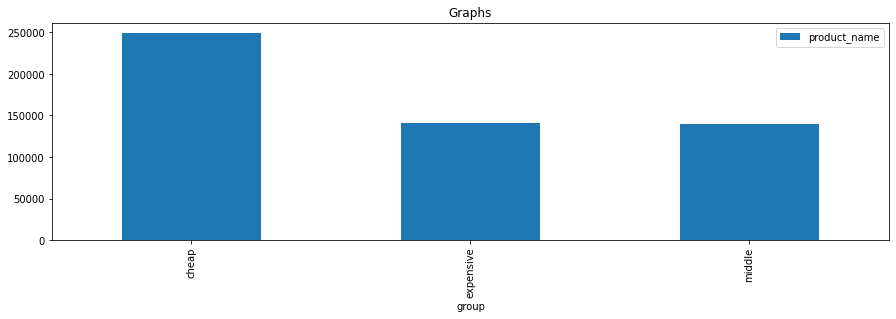

In [30]:
data_clean.groupby('group')['product_name'].count().reset_index().plot(y='product_name',x='group', kind='bar',figsize=(15, 4))
plt.title('Graphs'),
plt.xlabel('group')
plt.show()

**Company sales the most of "cheap" products(unit price less than 2). 
We see that the number of goods sold at low prices is much greater than at medium and high prices.
Revenue is directly proportional to the price of goods, respectively, "expensive"(unit price more than 4) goods bring more income than "cheap" ones. Therefore, the company should increase sales of "expensive" goods in the future.**

#### Creating groups: low popular, middle popular, high popular.

In [31]:
data_quantity=data_clean.groupby('product_name')['quantity'].sum().reset_index().sort_values(by='quantity',ascending=True)
data_quantity

In [32]:
data_quantity.describe()

In [33]:
def assign_popular_group(popular):
    if popular <= 100:
        return 'low_popular'
    elif popular <= 500:
        return 'middle_popular'
    else: 
        return 'high_popular'

In [34]:
data_quantity['group']=data_quantity['quantity'].apply(assign_popular_group)

In [35]:
data_quantity

**When analyzing the popularity of a product, it is necessary to take into account not only the number of sales, but also the number of buyers of this product. Since, if one client buys a product in large quantities, then this income may not be stable. Any financial problems or changes in the preferences of this client in the future - will deprive the company of sales of this product completely. Therefore, the company should increase not only the quantity of the product sold, but also the popularity of its products among various customers.**


## Carry out exploratory data analysis (EDA)

### Let's determine the change in prices of goods for the entire period belonging to different groups by popularity. (let's make a graph) How did the popularity of a product change with price?

In [36]:
data_clean_gr=data_clean.merge(data_quantity[['product_name','group']], on='product_name', how='outer')

In [37]:
data_clean_gr

In [38]:
data_clean_gr.groupby('group_y')["unit_price"].mean()

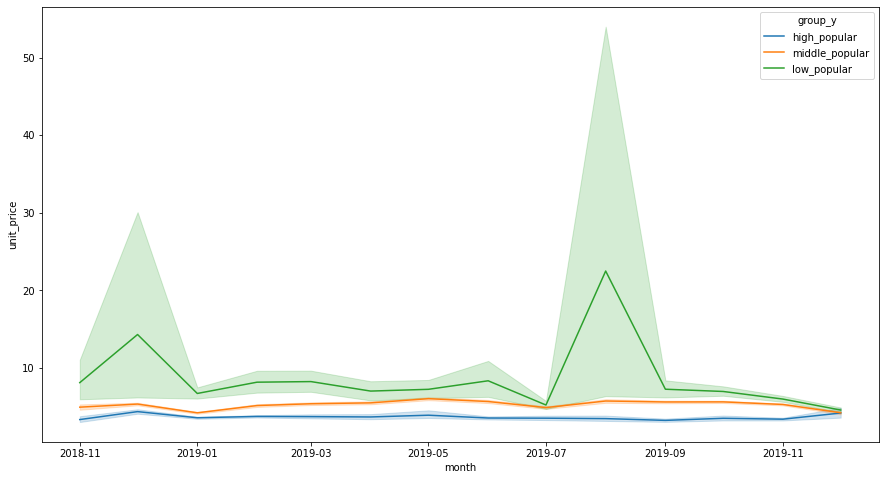

In [39]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(data=data_clean_gr, x="month", y="unit_price",hue="group_y")


**We see that the price per unit of high and medium popularity goods remains virtually unchanged throughout the year. And the prices for the most unpopular goods, on the contrary, have peak values in December and August. Perhaps it was because of the increase in prices that the goods did not sell as well, and this reduced their popularity.**

### Let's see the distribution of price categories in different groups by popularity. (histogram). Most popular cheap or expensive items?

In [40]:
data_clean_gr.groupby(['group_y','group_x'])["product_name"].count().reset_index()

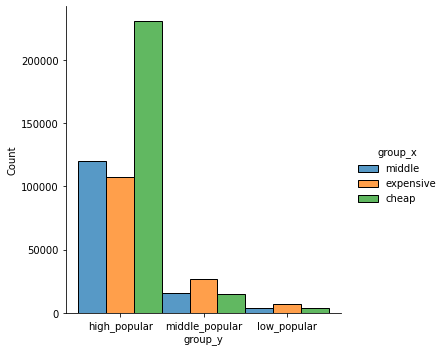

In [41]:
sns.displot(data_clean_gr, x='group_y', hue="group_x",multiple="dodge")

In [42]:
data_clean['product_name'].nunique()

**We can see that the range of products mainly consists of products of high popularity (sales of more than 500), but low value (unit price less than 2). In products with medium (sales from 100 to 500) and low (sales less than 100) popularity, there is no significant difference in unit cost.**

### Find products that have not been sold in the last 3 months. Might not be worth buying anymore.

In [43]:
data_no_sales=data_clean.query('month>"2019-09-01"').groupby(['product_name'])['quantity'].sum().reset_index().sort_values(by='quantity',ascending=True)

In [44]:
data_no_sales

In [45]:
data_no_sales.query('quantity==1')['product_name'].nunique()

In [46]:
data_no_sales.query('quantity==1')['product_name'].unique()

### We will find the products that have sold the most in the last 3 months, it may be worth increasing their number.

In [47]:
data_super_sales=data_clean.query('month>"2019-09-01"').groupby(['product_name'])['quantity'].sum().reset_index().sort_values(by='quantity',ascending=False)

In [48]:
data_super_sales.query('quantity>5000')['product_name'].nunique()

In [49]:
data_super_sales.query('quantity>5000')['product_name'].unique()

### We will find goods, which popular in different seasons of year and goods - popular in all seasons and will plot them. For creating plan of assortment of goods depend on seasons.

In [50]:
data_summer=data_clean.query('(order_date>="2019-06-01")and(order_date<="2019-08-31")')
print(data_summer['product_name'].nunique(),data_summer['product_name'].unique())

In [51]:
data_winter=data_clean.query('(order_date>="2018-12-01")and(order_date<="2019-02-28")')
print(data_winter['product_name'].nunique(),data_winter['product_name'].unique())

In [52]:
data_spring=data_clean.query('(order_date>="2019-03-01")and(order_date<="2019-05-31")')
print(data_spring['product_name'].nunique(),data_spring['product_name'].unique())

In [53]:
data_autumn=data_clean.query('(order_date>="2019-09-01")and(order_date<="2019-11-30")')
print(data_autumn['product_name'].nunique(),data_autumn['product_name'].unique())

Goods sold only in all summer:

In [54]:
data_summer_uniq=data_summer[np.logical_not(data_summer['product_name'].isin(data_autumn['product_name']))][np.logical_not(data_summer['product_name'].isin(data_winter['product_name']))][np.logical_not(data_summer['product_name'].isin(data_spring['product_name']))]

In [55]:
data_summer_uniq['product_name'].nunique()

**Goods sold only in autumn:**

In [56]:
data_autumn_uniq=data_autumn[np.logical_not(data_autumn['product_name'].isin(data_summer['product_name']))][np.logical_not(data_autumn['product_name'].isin(data_winter['product_name']))][np.logical_not(data_autumn['product_name'].isin(data_spring['product_name']))]

In [57]:
data_autumn_uniq['product_name'].nunique()

**Goods sold only in winter:**

In [58]:
data_winter_uniq=data_winter[np.logical_not(data_winter['product_name'].isin(data_summer['product_name']))][np.logical_not(data_winter['product_name'].isin(data_autumn['product_name']))][np.logical_not(data_winter['product_name'].isin(data_spring['product_name']))]

In [59]:
data_winter_uniq['product_name'].nunique()

**Goods sold only in spring:**

In [60]:
data_spring_uniq=data_spring[np.logical_not(data_spring['product_name'].isin(data_summer['product_name']))][np.logical_not(data_spring['product_name'].isin(data_autumn['product_name']))][np.logical_not(data_spring['product_name'].isin(data_winter['product_name']))]

In [61]:
data_spring_uniq['product_name'].nunique()

**Goods sold in all seasons:**

In [62]:
data_multi=data_clean[(data_clean['product_name'].isin(data_autumn['product_name'].unique()))&(data_clean['product_name'].isin(data_spring['product_name'].unique()))&(data_clean['product_name'].isin(data_winter['product_name'].unique()))&(data_clean['product_name'].isin(data_summer['product_name'].unique()))]

In [63]:
data_multi['product_name'].nunique()

In [64]:
data_multi

**Let's join tables:**

In [65]:
data_spring_uniq['season']='spring'
data_winter_uniq['season']='winter'
data_summer_uniq['season']='summer'
data_autumn_uniq['season']='autumn'
data_multi['season']='multiseasons'

In [66]:
data_season=data_spring_uniq.append(data_winter_uniq).append(data_summer_uniq).append(data_autumn_uniq).append(data_multi)

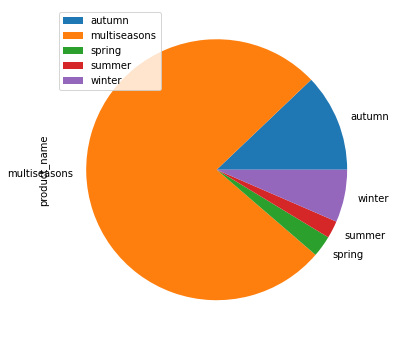

In [67]:
data_season.pivot_table(index='season', values='product_name',aggfunc='nunique').plot(y='product_name',kind='pie',figsize=(6,6))
plt.show()

***We see the most of the assortment are all-season goods and a smaller part are summer and spring***

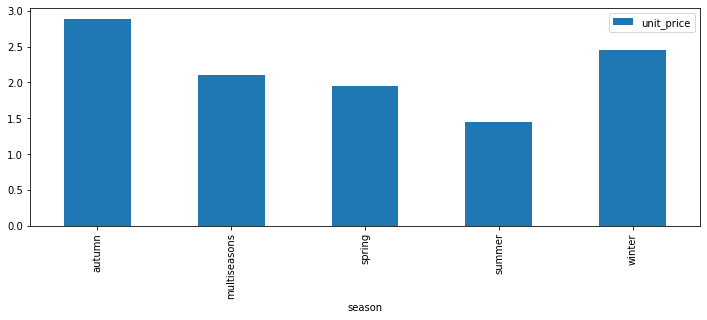

In [68]:
data_season.groupby('season')['unit_price'].median().reset_index().plot(y='unit_price',x='season', kind='bar',figsize=(12, 4))
plt.show()

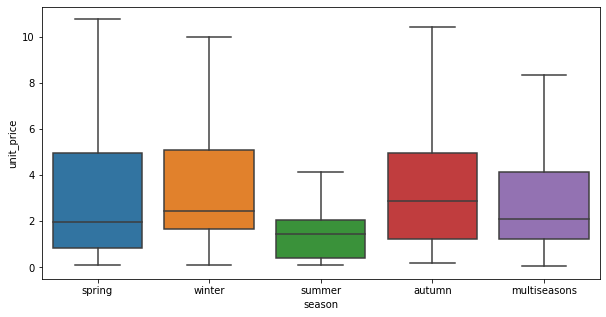

In [69]:
plt.figure(figsize=(10,5))
sns.boxplot(x='season',y='unit_price',data=data_season,showfliers = False)
plt.show()

***We see that autumn products have the highest average prices and summer - the lowest.***

## Checking hypothesises

Lets formulate null and an alternative hypothesises: <br>
 ***H0:The null hypothesis - the price of a highly popular product is statistically less than the price of a low popularity product.<br>
    H1:The alternative hypothesis -the price of a highly popular product isn't statistically less than the price of a low popularity product.***

In [70]:
data_clean_gr

In [71]:
data_high_popular=data_clean_gr.query('group_y=="high_popular"')
data_high_popular['unit_price']

In [72]:
data_low_popular=data_clean_gr.query('group_y=="low_popular"')

In [73]:
data_low_popular['unit_price'].describe()

In [74]:
data_high_popular['unit_price'].describe()

In [75]:
alpha =0.05
results = st.ttest_ind(data_high_popular['unit_price'],data_low_popular['unit_price'], equal_var=False, alternative='less')
print('p-value:', results.pvalue)

In [76]:
if results.pvalue<alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

**When testing hypotheses, we used Student's test, since we had two samples of values, and it was necessary to check how the means of these samples are equal. Samples are independence, so we used  "two-sided test"- "st.ttest_ind".**

**The p-value<alpha, so we cannot say that high-popular products have lower prices than low popularity products.**

## Conslutions

After analyzing the range of goods, we can draw the following conclusions:<br>

1) The store does not specialize in a particular type of goods - ***having 4026 different items.***<br>

2) Company sales the most of "cheap" products(unit price less than 2). We see that the number of goods sold at low prices is much greater than at medium and high prices. Revenue is directly proportional to the price of goods, respectively, "expensive"(unit price more than 4) goods bring more income than "cheap" ones. Therefore, ***the company should increase sales of "expensive" goods in the future.***<br>

3) We see that the price per unit of high and medium popularity goods remains virtually unchanged throughout the year. And the prices for ***the most unpopular goods, on the contrary, have peak values in December and August.*** Perhaps it was because of the increase in prices that the goods did not sell as well, and this reduced their popularity. <br>

4) We can see that the range of products mainly consists of products of ***high popularity (sales of more than 500), but low value (unit price less than 2).*** In products with medium (sales from 100 to 500) and low (sales less than 100) popularity, there is no significant difference in unit cost.<br>

5) We found ***108 products that sold only once in the last three months*** - it may be worth refusing to purchase these products in the future, unless these are seasonal products and their sales peak at another time of the year.<br>

6) We found ***28 types of goods that were sold in the largest quantity in the last 3 months.*** After checking them for seasonality, you can also increase their purchases.<br>

7) The assortment contains seasonal goods and all-season goods. ***The most of the assortment are all-season goods and a smaller part are summer and spring.***<br>

8) That ***autumn*** products have the ***highest average prices*** and ***summer - the lowest.***<br>

9) After testing the hypothesis that ***the most popular products have a lower price, with two-side t-test, we concluded that this is not the case.***